<a href="https://colab.research.google.com/github/hachteja/CNMF-PS/blob/main/CNMF_Pan_Sharpening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNMF Pan-Sharpening
## A notebook for enhanced analysis of hyperspectral STEM-EELS datasets
## 12.22.20
## Notebook created by Jordan A. Hachtel and Nikolay S. Borodinov

Here, combined non-negative matrix factorization (CNMFS) pan-sharpening (PS) to combine two hyperspectral datasets, one with high spatial resolution (HSR) and one with high spectral fidelity (HSF), to gain a single dataset with the beneficial properties of both.

Included with this notebook is a link to sample data used in the published paper concerning this technique (link to come). These datasets are acquired using monochromated electron energy-loss spectroscopy (EELS) in the scanning transmission electron microscope (STEM). The samples are plasmonic assemblies of fluorine and tin doped indium oxide (FT:IO) nanoparticles. 

For any questions concerning this code, please address correspondence to hachtelja@ornl.gov. 

In [ ]:
#@title Import Libraries

import numpy as np
import json
import copy
import math
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from scipy import interpolate
from sklearn.decomposition import NMF
from skimage.transform import resize
from matplotlib.patches import Rectangle
from pylab import cm

In [14]:
#@title Define Functions

def CalibrateSI(SI,disp,e_s,e_f,int_lim=None,N=5000):
    """
    Performs sub-pixel fitting of the hyperspectral dataset and calibrates 
    to single energy axis.
    
    Input:  SI        - as acquired hyperspectral dataset (numpy array)
            disp      - dispersion in meV/spectrometer channel (float)
            e_s       - starting energy of calibrated energy axis (float)
            e_f       - finishing energy of calibrated energy axis (float)
    Optional: int_lim - intensity limit for sub-pixel ZLP fitting (int)
                          Default: None
              N       - number of interpolated datapoints on calibrated energy axis (int) 
                            Default: 5000
    Output: Eout      - calibrated energy axis (numpy array)
            SIout     - calibrated spectrum image (numpy array)
    """    

    dims=SI.shape
    Einit=np.arange(0,dims[2])*disp
    Eax=np.zeros_like(SI)
    avc=Einit[np.argmax(np.average(SI,axis=(0,1)))]
    for i in range(dims[0]):
        for j in range(dims[1]):
            s=SI[i,j];smax=np.amax(s);smaxi=np.argmax(s)
            if int_lim: 
                if np.amax(s)<int_lim: Eax[i,j]=Einit-avc;continue
            lh=Einit[np.argmin(np.abs(s[:smaxi]/smax-0.5))]
            uh=Einit[np.argmin(np.abs(s[smaxi:]/smax-0.5))+smaxi]
            Eax[i,j]=Einit-np.average([uh,lh])            
    m,M=np.amax(np.amin(Eax,axis=(2))),np.amin(np.amax(Eax,axis=(2)))
    Eout=np.linspace(e_s,e_f,N,endpoint=True)
    SIout=np.array([[interpolate.interp1d(e,s)(Eout) for e,s in zip(erow,srow)] for erow,srow in zip(Eax,SI)])
    SIav=np.average(SI[:,:,-50:])
    SIout=SIout-SIav
    return Eout,SIout


In [15]:
#@title Download Sample Data from Google Drive

!gdown https://drive.google.com/uc?id=1jGCW1vqUr_53GoOQ_5BkSID5Jx7LIWE6
!gdown https://drive.google.com/uc?id=1f5dVSNWiVkO0PFsJlTAZRU1SVXa5V_no
!gdown https://drive.google.com/uc?id=1T_iRn84W0OM0O3W5bYmoKHSkKJR49Gk2
!gdown https://drive.google.com/uc?id=1qr5P0fgEqfJlHVqT-mvbkZ02bzfZmEYM

Downloading...
From: https://drive.google.com/uc?id=1jGCW1vqUr_53GoOQ_5BkSID5Jx7LIWE6
To: /content/HSF_metadata.json
100% 4.38k/4.38k [00:00<00:00, 3.68MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f5dVSNWiVkO0PFsJlTAZRU1SVXa5V_no
To: /content/HSF_data.npy
10.0MB [00:00, 37.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1T_iRn84W0OM0O3W5bYmoKHSkKJR49Gk2
To: /content/HSR_data.npy
369MB [00:03, 97.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qr5P0fgEqfJlHVqT-mvbkZ02bzfZmEYM
To: /content/HSR_metadata.json
100% 4.39k/4.39k [00:00<00:00, 3.68MB/s]


In [34]:
#@title Calibrate Datasets

# Load datasets 
# Format: 3D numpy array (2 spatial, 1 spectral dimension)
HSF_dat=np.load('/content/HSF_data.npy')
HSR_dat=np.load('/content/HSR_data.npy')

# Load dispersions and calibrations 
# Here, we load from json strings, but calibration and disperison can be set manually (floats)
HSR_mdat=json.load(open('/content/HSR_metadata.json','r'))
HSF_mdat=json.load(open('/content/HSF_metadata.json','r'))
HSR_cal=HSR_mdat['spatial_calibrations'][1]['scale']
HSF_cal=HSF_mdat['spatial_calibrations'][1]['scale']
HSR_disp=HSR_mdat['spatial_calibrations'][2]['scale']
HSF_disp=HSF_mdat['spatial_calibrations'][2]['scale']

# Create Calibrated SI and Energy Arrays (use same parameters for calibration for both datasets)

E_HSR,SI_HSR=CalibrateSI(HSR_dat,HSR_disp,e_s=-0.025,e_f=1.,int_lim=10000)
E_HSF,SI_HSF=CalibrateSI(HSF_dat,HSF_disp,e_s=-0.025,e_f=1.,int_lim=10000)

# Note: For the sample dataset we use int_lim=10000, meaning that subpixel fitting is not performed 
# on spectra where the zlp has less than 10000 counts. This is done because the FI:TO particles in
# the sample dataset are thick (>150 nm) and made of a heavy material, and the beam does not 
# penetrate the particles and there are not enough counts in the ZLP to fit. For this system, there
# is also no plasmonic signal in these spectra, but for thinner materials int_lim should be lowered 
# or removed completely during the calibration step.

# Check to see if energy axis calibration is identical between HSF and HSR dataset. If E_HSF and 
# E_HSR are not identical readjust e_s and e_f values until energy axes are identical.
if (E_HSF==E_HSR).all(): 
    print('Identical')
else: print('Non-Identical')

Identical


In [35]:
#@title Preprocess Datasets

# The elastic scattering peak must be removed in order to do NMF decompositions of any kind
# here we perform a simple removal of the ZLP by cutting off all values below 0.2 eV. 

# Select cutoff energy
E_cut=0.2
i_cut=np.argmin(np.abs(E_HSF-E_cut))

# Create final datasets for PS process
E_PS=E_HSR[i_cut:]
HSR=SI_HSR[:,:,i_cut:]
HSF=SI_HSF[:,:,i_cut:]
HSRdim=HSR.shape
HSFdim=HSF.shape

In [36]:
#@title Perform HSF Decomposition

# Choose number of components for CNMF Reconstruction
ncomp=9

# Perform NMF decomposition
HSF_NMF=copy.deepcopy(HSF)
HSF_NMF[HSF_NMF<0]=0
HSF_NMF_flat=HSF_NMF.reshape(np.prod(HSFdim[:2]),HSFdim[2])
HSF_model=NMF(ncomp,max_iter=10000)
HSF_maps=HSF_model.fit_transform(HSF_NMF_flat).reshape(HSFdim[:2]+(ncomp,))
HSF_endmembers=HSF_model.components_

# Resize HSF_maps to the same dimensions as HSR acquisition
HSF_maps_HSR=resize(HSF_maps,HSRdim[:2]+(ncomp,)).reshape(np.prod(HSRdim[:2]),ncomp)

In [37]:
#@title Perform HSR Decomposition (Note: Only for comparison, not used in CNMF process)

HSR_NMF=copy.deepcopy(HSR)
HSR_NMF[HSR_NMF<0]=0
HSR_NMF_flat=HSR_NMF.reshape(np.prod(HSRdim[:2]),HSRdim[2])
HSR_model=NMF(ncomp,max_iter=10000)
HSR_maps=HSR_model.fit_transform(HSR_NMF_flat).reshape(HSRdim[:2]+(ncomp,))
HSR_endmembers=HSR_model.components_

In [38]:
#@title Perform CNMF Pan-Sharpening of HSR Dataset

PS_NMF=copy.deepcopy(HSR)
PS_NMF[PS_NMF<0]=0
PS_NMF_flat=PS_NMF.reshape(np.prod(HSRdim[:2]),HSRdim[2])
PS_model=NMF(ncomp,init='custom',random_state=0,solver='mu',max_iter=10000)
PS_maps=PS_model.fit_transform(PS_NMF_flat,H=HSF_endmembers, W=HSF_maps_HSR).reshape(HSRdim[:2]+(ncomp,))
PS_endmembers=PS_model.components_

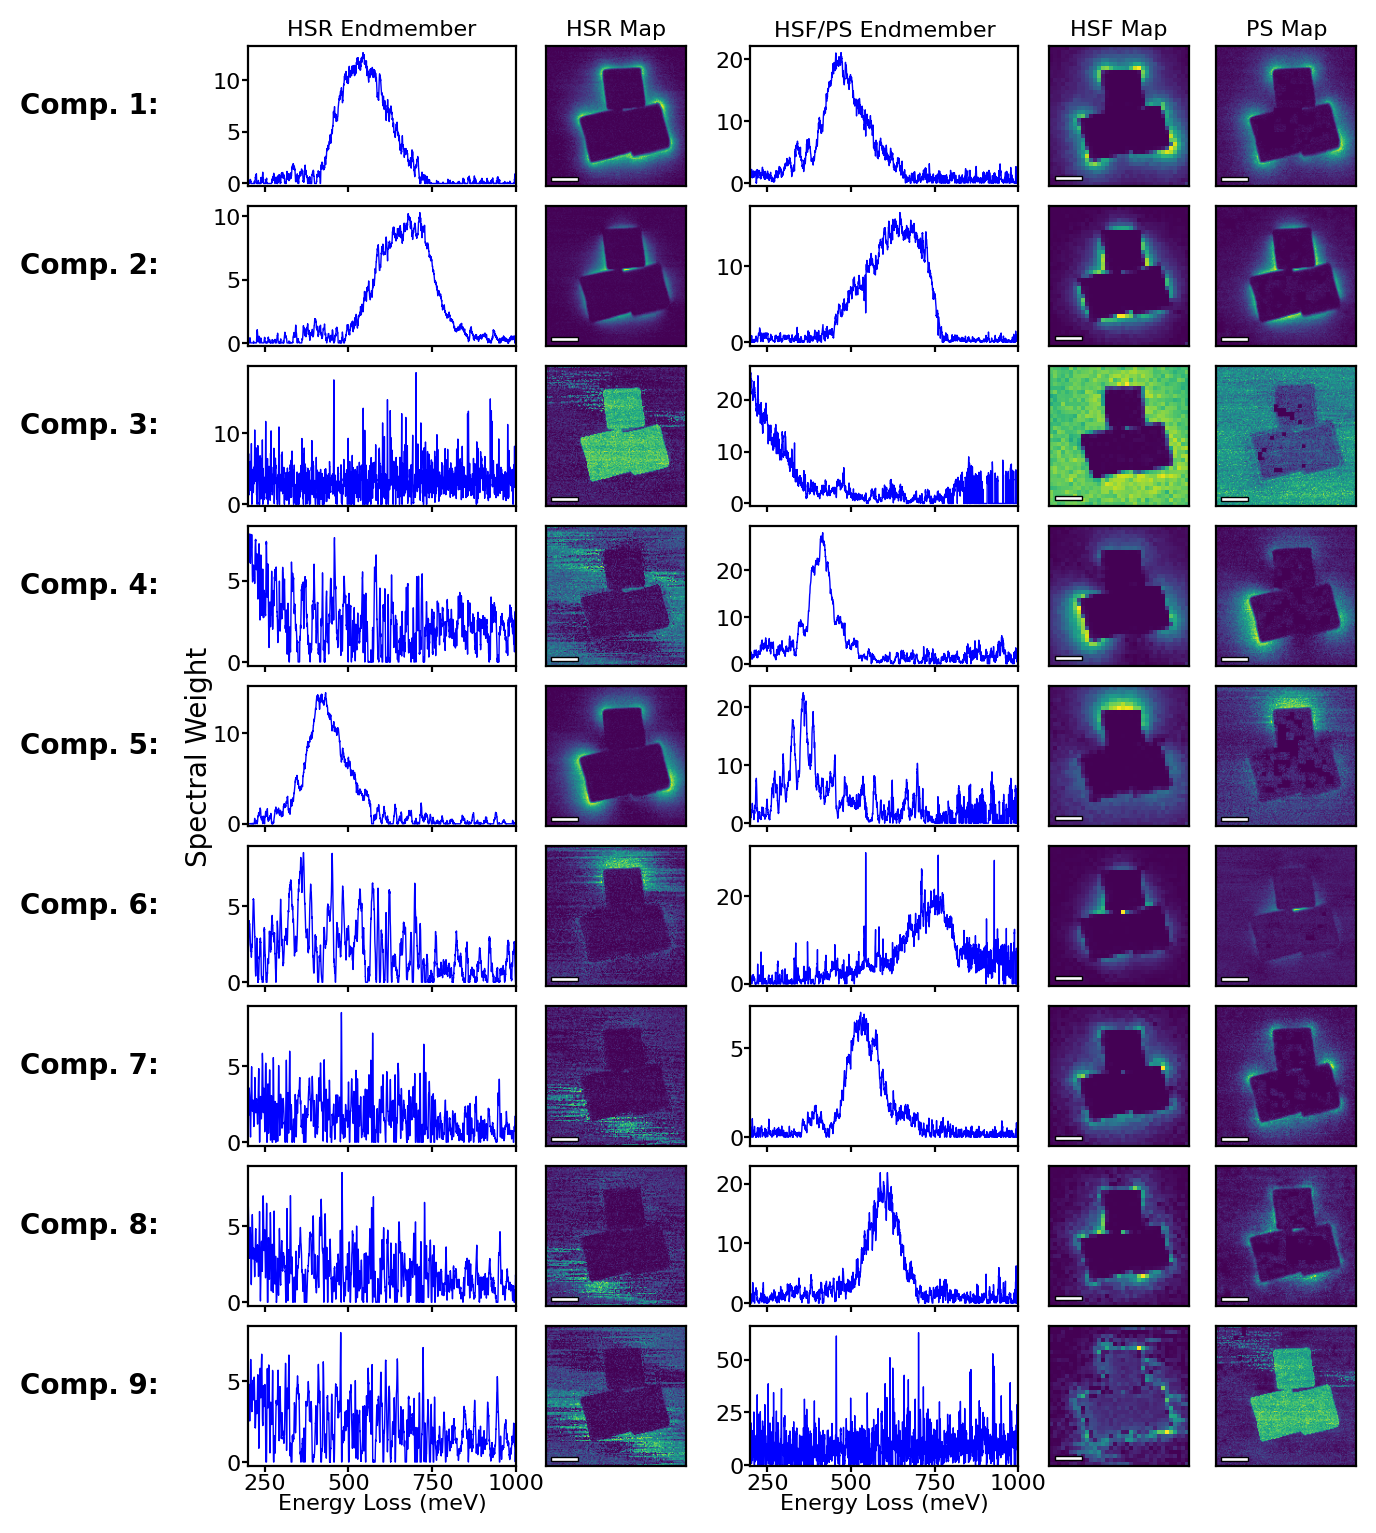

In [42]:
#@title Visualize: Individual Maps and Endmembers

fig=plt.figure(dpi=200,figsize=(6.7,0.8*ncomp))

for i in range(ncomp):
    #Plot HSR Endmembers
    ax=fig.add_axes([0.1,1-(i+1)/ncomp,0.2,0.875/ncomp])
    ax.plot(E_PS*1000,HSR_endmembers[i],color='b',lw=0.5)
    ax.tick_params(labelsize=8,length=2,pad=0.5)
    ax.set_xlim(E_PS[0]*1000,1000);ax.set_ylim(-0.25)
    if i==ncomp-1: ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=0)
    else: ax.set_xticklabels([])
    if i==4: ax.set_ylabel('Spectral Weight',fontsize=10,labelpad=0)
    if i==0: ax.set_title('HSR Endmember',fontsize=8,ha='center',va='center')

    #Plot HSR Abundance Maps
    ax=fig.add_axes([0.3,1-(i+1)/ncomp,0.15,0.875/ncomp],xticks=[],yticks=[])
    ax.imshow(HSR_maps[:,:,i],vmin=0)
    ax.add_patch(Rectangle((4,140),100/HSR_cal,4,fc='w',ec='k',lw=0.5))
    ax.text(-490,78,'Comp. '+str(i+1)+':',fontsize=10,ha='center',va='bottom',fontweight='bold')
    if i==0: ax.set_title('HSR Map',fontsize=8,ha='center',va='center')
    
    #Plot HSF and PS Endmembers
    ax=fig.add_axes([0.475,1-(i+1)/ncomp,0.2,0.875/ncomp])
    ax.plot(E_PS*1000,HSF_endmembers[i],color='b',lw=0.5)
    ax.tick_params(labelsize=8,length=2,pad=0.5)
    ax.set_xlim(E_PS[0]*1000,1000);ax.set_ylim(-0.5)
    if i==0: ax.set_title('HSF/PS Endmember',fontsize=8,ha='center',va='center')
    if i==ncomp-1: ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=0)
    else: ax.set_xticklabels([])
        
    #Plot HSF Abundance Maps
    ax=fig.add_axes([0.675,1-(i+1)/ncomp,0.15,0.875/ncomp],xticks=[],yticks=[])
    ax.imshow(HSF_maps[:,:,i],vmin=0)
    ax.add_patch(Rectangle((1,32),100/HSF_cal,1,fc='w',ec='k',lw=0.5))
    if i==0: ax.set_title('HSF Map',fontsize=8,ha='center',va='center')

    #Plot PS Abundance Maps
    ax=fig.add_axes([0.8,1-(i+1)/ncomp,0.15,0.875/ncomp],xticks=[],yticks=[])
    ax.imshow(PS_maps[:,:,i],vmin=0)
    ax.add_patch(Rectangle((4,140),100/HSR_cal,4,fc='w',ec='k',lw=0.5))     
    if i==0: ax.set_title('PS Map',fontsize=8,ha='center',va='center')

In [43]:
#@title Reconstruct Pan-sharpened dataset

PS=np.reshape(np.matmul(PS_maps,PS_endmembers),HSRdim)
PSmins=np.average(PS[:,:,-50:],axis=2)
PS=(PS.transpose(2,0,1)-PSmins).transpose(1,2,0)

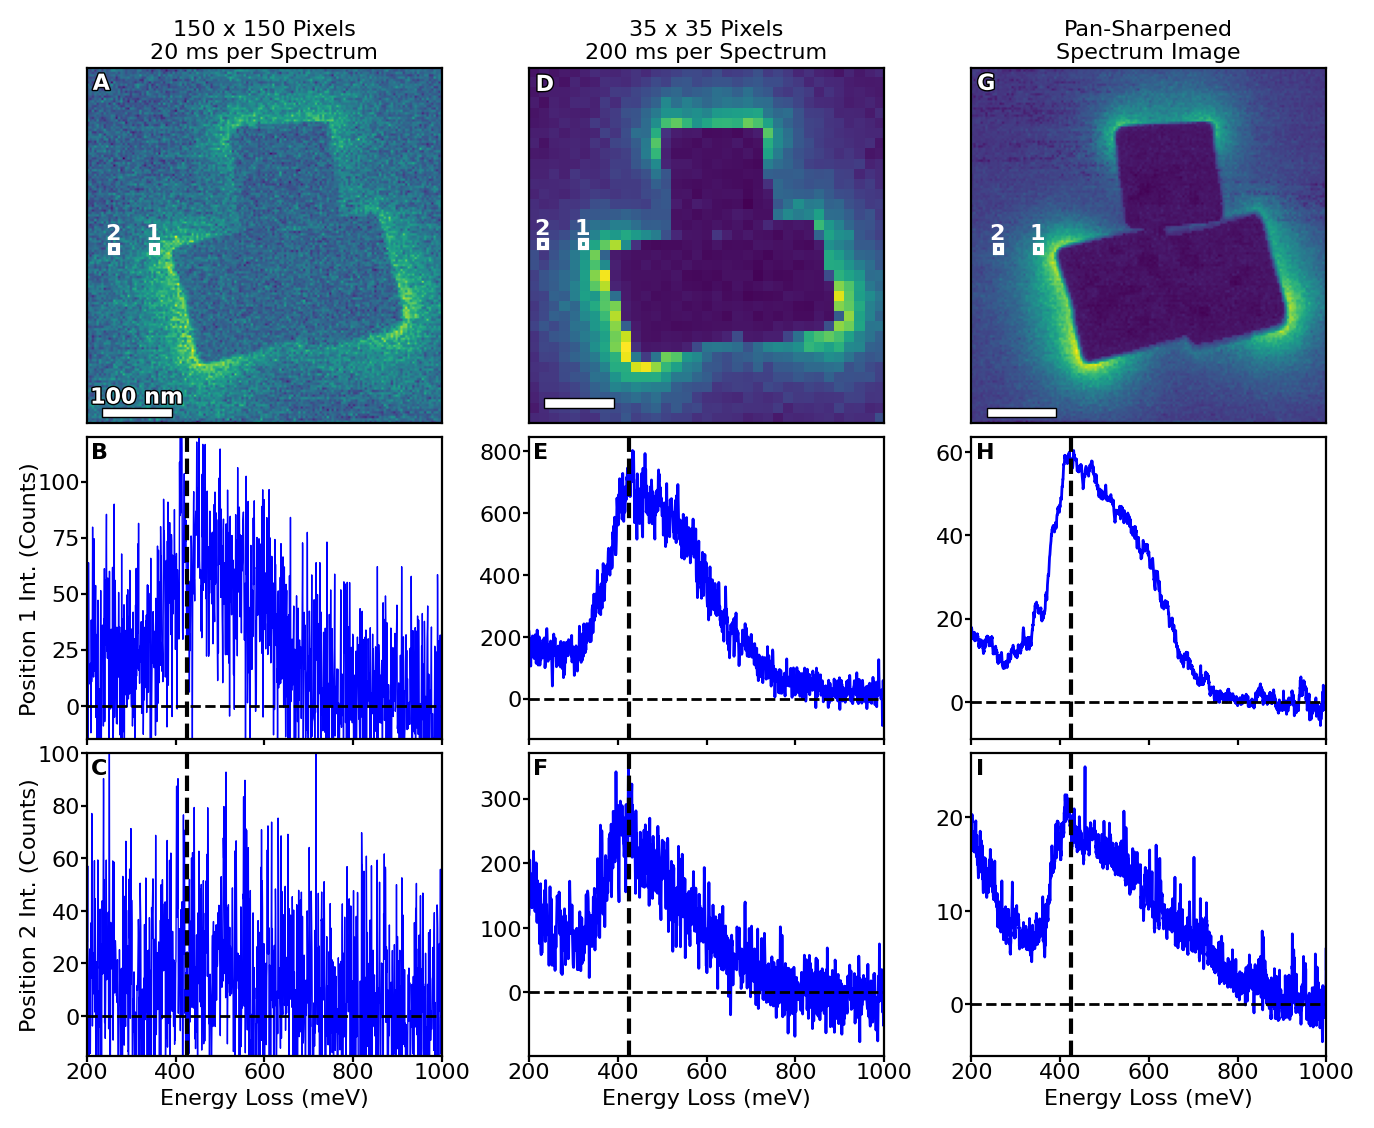

In [46]:
#@title Visualize: Pan-Sharpened Dataset

# Set energy value for energy-filtered slices of hyperspectral datasets
E_slice=0.425
i_slice=np.argmin(np.abs(E_PS-E_slice))

# Set pixel values for comparison
R1_pix=27,75
R2_pix=10,75

w,h=6.7,5.5;wh=w/h
fig=plt.figure(figsize=(w,h),dpi=200)

#Plot HSR Slice
ax=fig.add_axes([0.055,0.63,0.265,0.265*wh],xticks=[],yticks=[])
ax.imshow(HSR[:,:,i_slice])
ax.add_patch(Rectangle((R1_pix[0]-0.5,R1_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.add_patch(Rectangle((R2_pix[0]-0.5,R2_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.text(R1_pix[0]+0.5,R1_pix[1]-1.5,'1',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.text(R2_pix[0]+0.5,R2_pix[1]-1.5,'2',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.add_patch(Rectangle((6,143),100/HSR_cal,4,fc='w',ec='k',lw=0.5))
txt=ax.text(6+50/HSR_cal,143,'100 nm',color='w',fontweight='bold',fontsize=8,ha='center',va='bottom')
txt.set_path_effects([path_effects.withStroke(linewidth=1, foreground='k')])
ax.set_title('150 x 150 Pixels\n20 ms per Spectrum',fontsize=8,y=0.98)
txt=ax.text(2,2,'A',color='w',fontweight='bold',fontsize=8,ha='left',va='top')
txt.set_path_effects([path_effects.withStroke(linewidth=1,foreground='k')])

#Plot HSR Slice
ax=fig.add_axes([0.385,0.63,0.265,0.265*wh],xticks=[],yticks=[])
ax.imshow(HSF[:,:,i_slice])
R1_pix_HSF=int(R1_pix[0]*HSR_cal/HSF_cal)-1,int(R1_pix[1]*HSR_cal/HSF_cal)
R2_pix_HSF=int(R2_pix[0]*HSR_cal/HSF_cal)-1,int(R2_pix[1]*HSR_cal/HSF_cal)
ax.add_patch(Rectangle((R1_pix_HSF[0]-0.5,R1_pix_HSF[1]-0.5),0.75,0.75,fc='None',ec='w',lw=1.5))
ax.add_patch(Rectangle((R2_pix_HSF[0]-0.5,R2_pix_HSF[1]-0.5),0.75,0.75,fc='None',ec='w',lw=1.5))
ax.text(R1_pix_HSF[0]-0.25,R1_pix_HSF[1]-.75,'1',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.text(R2_pix_HSF[0]-0.25,R2_pix_HSF[1]-.75,'2',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.add_patch(Rectangle((1,32),100/HSF_cal,1,fc='w',ec='k',lw=0.5))
ax.set_title('35 x 35 Pixels\n200 ms per Spectrum',fontsize=8,y=0.98)
txt=ax.text(0.15,0.2,'D',color='w',fontweight='bold',fontsize=8,ha='left',va='top')
txt.set_path_effects([path_effects.withStroke(linewidth=1,foreground='k')])

#Plot PS Slice
ax=fig.add_axes([0.715,0.63,0.265,0.265*wh],xticks=[],yticks=[])
ax.imshow(PS[:,:,i_slice])
ax.add_patch(Rectangle((R1_pix[0]-0.5,R1_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.add_patch(Rectangle((R2_pix[0]-0.5,R2_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.text(R1_pix[0]+0.5,R1_pix[1]-1.5,'1',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.text(R2_pix[0]+0.5,R2_pix[1]-1.5,'2',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.add_patch(Rectangle((6,143),100/HSR_cal,4,fc='w',ec='k',lw=0.5))
ax.set_title('Pan-Sharpened\nSpectrum Image',fontsize=8,y=0.98)
txt=ax.text(2,2,'G',color='w',fontweight='bold',fontsize=8,ha='left',va='top')
txt.set_path_effects([path_effects.withStroke(linewidth=1,foreground='k')])

#Plot HSR Representative Spectrum
ax=fig.add_axes([0.055,0.3425,0.265,0.275])
ax.plot(E_PS*1000,HSR[R1_pix[1],R1_pix[0]],color='b',lw=0.5)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E_PS[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_ylabel('Position 1 Int. (Counts)',fontsize=8,labelpad=-1)
ax.set_ylim(-15,120)
ax.text(E_PS[0]*1000+10,ax.get_ylim()[1]*0.98,'B',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xticklabels([])

ax=fig.add_axes([0.055,0.055,0.265,0.275])
ax.plot(E_PS*1000,HSR[R2_pix[1],R2_pix[0]],color='b',lw=0.5)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E_PS[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)
ax.set_ylabel('Position 2 Int. (Counts)',fontsize=8,labelpad=-1)
ax.set_ylim(-15,100)
ax.text(E_PS[0]*1000+10,ax.get_ylim()[1]*0.98,'C',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')

#Plot HSF Representative Spectrum
ax=fig.add_axes([0.385,0.3425,0.265,0.275])
ax.plot(E_PS*1000,HSF[R1_pix_HSF[1],R1_pix_HSF[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E_PS[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.text(E_PS[0]*1000+10,ax.get_ylim()[1]*0.98,'E',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xticklabels([])

ax=fig.add_axes([0.385,0.055,0.265,0.275])
ax.plot(E_PS*1000,HSF[R2_pix_HSF[1],R2_pix_HSF[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E_PS[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.text(E_PS[0]*1000+10,ax.get_ylim()[1]*0.98,'F',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)

#Plot PS Representative Spectrum
ax=fig.add_axes([0.715,0.3425,0.265,0.275])
ax.plot(E_PS*1000,PS[R1_pix[1],R1_pix[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E_PS[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)
ax.text(E_PS[0]*1000+10,ax.get_ylim()[1]*0.98,'H',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xticklabels([])

ax=fig.add_axes([0.715,0.055,0.265,0.275])
ax.plot(E_PS*1000,PS[R2_pix[1],R2_pix[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E_PS[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)
ax.text(E_PS[0]*1000+10,ax.get_ylim()[1]*0.98,'I',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')